## Analysing daily PQs about EVs

In [7]:
import pandas as pd
import re
import requests
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [8]:
# !python download.py

In [9]:
# Naughtily, we're importing a database of MP ids & party affiliations from elsewhere... 
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

In [10]:
# Check we get Angie Rayner here
all_p[all_p.id == 4356]

,id,nameListAs,gender,latestPartyabbreviation
437,4356,"Rayner, Angela",F,Lab


In [11]:
id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [12]:
wpqs = pd.read_csv('tmp/ua_pqs.csv')
wpqs['dateTabled'] = pd.to_datetime(wpqs.dateTabled)
wpqs['heading'] = wpqs.heading.fillna('')
# wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateTabled', 'questionText', 'answeringBodyName', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

# Make some of the string fields lower case to improve comparability and searchability
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

wpqs['year_month'] = wpqs.dateTabled.dt.to_period('M')

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/ua_pqs.csv'

In [ ]:
# Cleaning up the question text

# Aim: to get the bit of text after the 'to ask the secretary of state for blah blah, if...'

def question_cleaner(question):
    q = re.sub(r',(?=\S)|:', ', ', question)
    q = q.replace("to ask her majesty's government ", "to ask her majesty's government, ").replace("to ask her majesty’s government ", "to ask her majesty's government, ")
    q = q.replace(', and', ' and').replace('foreign, commonwealth and development affairs', 'foreign commonwealth and development affairs').replace('digital, culture, media', 'digital culture media').replace('business, energy and industrial', 'business energy and industrial')
    q = q.replace('levelling up, housing and', 'levelling up housing and').replace('environment, food and rural affairs', 'environment food and rural affairs').replace('culture, media and sport', 'culture media and sport').replace('business, innovation and skills', 'business innovation and skills')
    q = q.replace('digital, culture, media and sport', 'digital culture media and sport')
    q = q.replace('housing, communities and local government', 'housing communities and local government')
    q = q.replace(', representing the church commissioners', ' representing the church commissioners, ') 
    q = q.replace('to ask the chairman of committees ', 'to ask the chairman of committees, ')
    q = q.replace('to ask the leader of the house ', 'to ask the leader of the house, ')
    q = q.replace("to ask her majesty’s government", "to ask her majesty's government, ")
    q = q.replace("to ask the senior deputy speaker ", "to ask the senior deputy speaker, ")
    q = q.replace("her majesty's government ", "her majesty's government, ")
    q = q.replace("to ask the secretary of state for education ", "to ask the secretary of state for education, ")
    q = q.replace("to ask the secretary of state for defence ", "to ask the secretary of state for defence, ")
    q = q.replace("to ask the secretary of state for work and pensions ", "to ask the secretary of state for work and pensions, ")
    q = q.replace("to ask the secretary of state for environment food and rural affairs ", "to ask the secretary of state for environment food and rural affairs, ")
    q = q.replace("to ask the secretary of state for health ", "to ask the secretary of state for health, ")
    q = q.replace("foreign and commonwealth affairs ", "foreign and commonwealth affairs, ")
    q = q.replace("foreign commonwealth and development affairs ", "foreign commonwealth and development affairs, ")
    q = q.replace("the senior deputy speaker ", "the senior deputy speaker, ")
    q = q.replace("secretary of state for the home department,", "secretary of state for the home department, ")
    q = q.replace("to ask mr chancellor of the exchequer ", "to ask mr chancellor of the exchequer, ")
    q = q.replace("to ask the minister of the cabinet office ", "to ask the minister of the cabinet office, ")
    q = q.replace("to ask the minister for the cabinet office ", "to ask the minister for the cabinet office, ")
    q = q.replace("to ask the secretary of state for communities and local government ", "to ask the secretary of state for communities and local government, ")
    q = ' '.join(q.split(', ')[1:])
    cleaned_question = q
    return cleaned_question

wpqs['cleanedQuestion'] = wpqs.questionText.progress_apply(lambda x: question_cleaner(x))

# Classify whether a question is about an EV

In [ ]:
# Manually label EVs
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'electric vehicle' in row.cleanedQuestion else 0, axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'electric car' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'public charging' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'gigafactory' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'electric battery' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'vehicle charging' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'car grant' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'homecharge' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'workplace charging' in row.cleanedQuestion else row['ELECTRICV'], axis=1)
wpqs['ELECTRICV'] = wpqs.progress_apply(lambda row: 1 if 'on-street residential' in row.cleanedQuestion else row['ELECTRICV'], axis=1)

In [ ]:
ev_pqs = wpqs[wpqs.ELECTRICV == 1]

In [ ]:
ev_pqs = ev_pqs[['year_month', 'dateTabled', 'askingMemberId', 'latestPartyabbreviation', 'house', 'cleanedQuestion']]

In [ ]:
# ev_pqs.set_index(['dateTabled'])[['askingMemberId']].resample('W').nunique().rolling(12).mean().plot(legend=False)

In [ ]:
n_mps_party = ev_pqs.groupby(['dateTabled', 'latestPartyabbreviation']).nunique()[['askingMemberId']].reset_index('latestPartyabbreviation')

In [ ]:
n_mps_party = n_mps_party.pivot(columns='latestPartyabbreviation', values='askingMemberId').fillna(0)

In [ ]:
n_mps_party.head()

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))

plot_sel = n_mps_party#.resample('W').sum()
plot_sel = plot_sel[plot_sel.index > '2021-01-01']

ax.plot(plot_sel.Lab, c='r', label='Labour')
ax.plot(plot_sel.Con, c='b', label='Conservative')
ax.plot(plot_sel.LD, c='y', label='Liberal Democrat')
ax.plot(plot_sel.SNP, c='gold', label='SNP')
ax.plot(plot_sel.sum(axis=1), c='black', label='Total MPs asking PQs')

ax.legend(title='Party')

## Make a WordCloud of EV quesitons

In [70]:
from wordcloud import WordCloud

In [90]:
# Set the date here

date = '2022-02-23'

In [91]:
ev_pqs.head()

,year_month,dateTabled,askingMemberId,latestPartyabbreviation,house,cleanedQuestion
11815,2014-09,2014-09-08,249,Con,Commons,what assessment he has made of the comprehensi...
27572,2015-01,2015-01-15,1521,Lab,Commons,how many ultra low emission vehicles of what m...
40813,2015-06,2015-06-12,146,Lab,Commons,how many publicly-funded charging points for e...
40837,2015-06,2015-06-12,146,Lab,Commons,what his department's budget was for new charg...
41542,2015-06,2015-06-09,4131,DUP,Commons,what assessment he has made of the possible da...


In [92]:
# Filter out the Lords, whose questions take a different format
wordcloud_df = ev_pqs.copy()

# Make a long string of all the questions. 

# Each question starts in the form "To ask the secretary of state for X, what [question text]". We'll get the bit after the "what, "
question_text = wordcloud_df[wordcloud_df.dateTabled == date].cleanedQuestion.tolist()
# question_text = wpqs_sel[wpqs_sel.year_month == date].cleanedQuestion.tolist()
    
# Clean out a few meaningless words that appear over and over
question_text = [x.replace('.', ' ').replace(' take ', ' ').replace('agencies remove', ' ').replace(' department ', ' ').replace('publish', '').replace(' government ', ' ').replace('pursuant', '').replace('question', '').replace('answer', '').replace('reference', '').replace(' effect ', ' ').replace(' make ', ' ').replace(' ensure ', ' ').replace('steps', '').replace(' assessment ', ' ').replace('taking', '').replace('made', '').replace('will', '') for x in question_text]
question_text = [x.replace('many', '').replace('whether', '').replace('(b)', '').replace('(a)', '') for x in question_text]
question_text = [x.replace('people', '').replace(' support ', ' ').replace(' s ', '').replace(' plans ', ' ').replace(' plan ', ' ') for x in question_text]
question_text = [x.replace(' application ', ' ').replace(' applications ', ' ').replace(' level ', ' ').replace(' help ', ' ').replace(' administration ', ' ').replace(' discussion ', ' ').replace(' service ', '').replace('communities', '').replace(' discussions ', '').replace(' impact ', '').replace('january', '').replace('february', '').replace(' uk ', ' ').replace('recent', '').replace(' estimate ', ' ').replace(' number ', ' ').replace(' c ', '') for x in question_text]
question_text = [x.replace(' programme ', ' ').replace('department', '').replace(' proportion ', ' ').replace(' department ', ' ').replace(' england ', ' ').replace('potential merits', ' ').replace(' national ', ' ').replace(' may ', ' ').replace(' statement ', ' ').replace(' year ', ' ').replace('(c)', ' ') for x in question_text]
question_text = [x.replace(' april ', ' ') for x in question_text]

long_string = ', '.join(question_text)

In [93]:
wordcloud = WordCloud(
    background_color='white', 
    max_words = 5000, 
    contour_width=3, 
    contour_color='steelblue', 
    width = 1500, 
    height=750
)

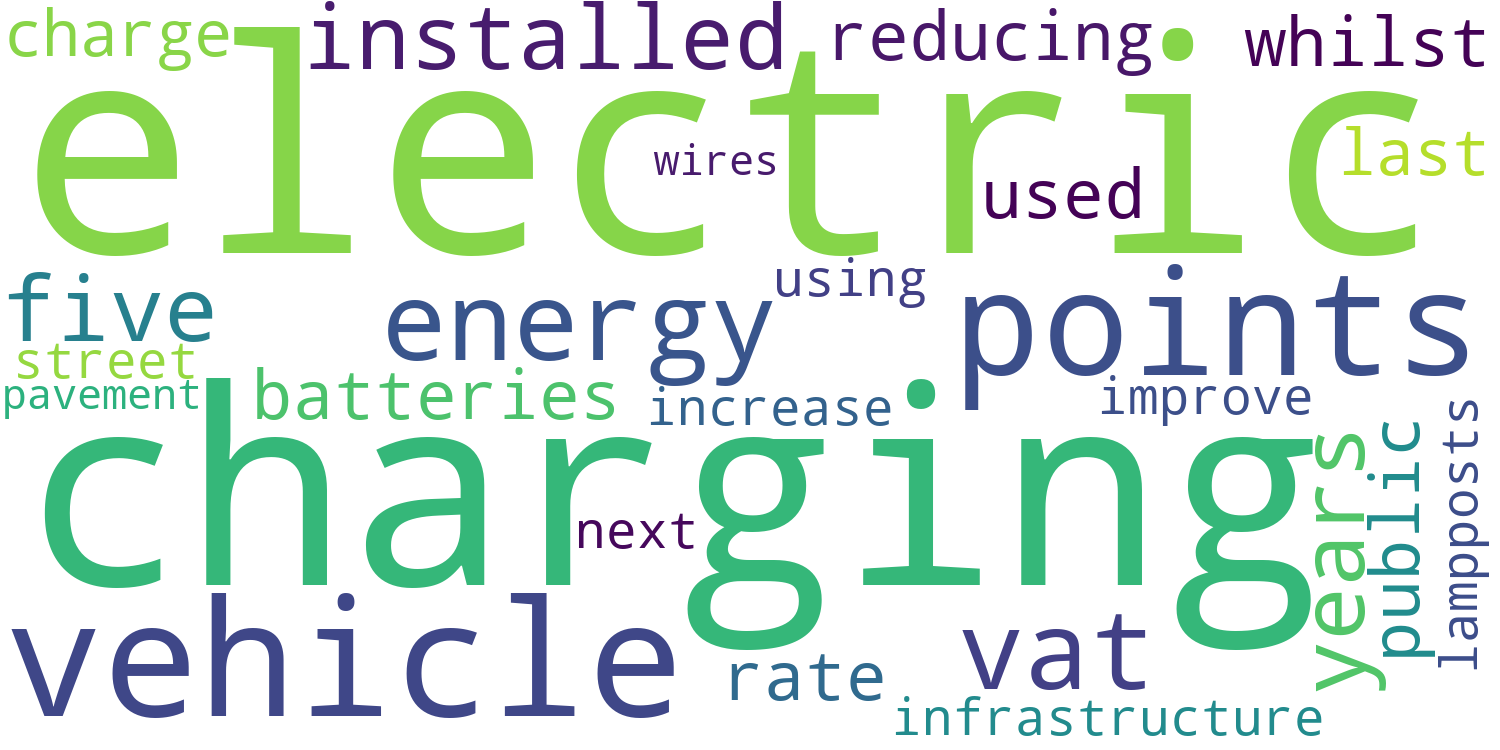

In [94]:
wordcloud.generate(long_string)
wordcloud.to_image()

# Interest in any issues

A function that can be used for a simple keyword search, returning the number of MPs asking about an issue on any given day.

In [64]:
keyword = 'coronavirus'
def get_num_mps_issue(issue):
    df = wpqs.copy()
    df = df[df.cleanedQuestion.str.contains(keyword)]
    df = df[['year_month', 'dateTabled', 'askingMemberId', 'latestPartyabbreviation', 'house', 'cleanedQuestion']]
    df = df.groupby(['dateTabled', 'latestPartyabbreviation']).nunique()[['askingMemberId']].reset_index('latestPartyabbreviation')
    df = df.pivot(columns='latestPartyabbreviation', values='askingMemberId').fillna(0)
    return df